In [1]:
"""
    Get cleaned data
"""

import numpy as np

dataset = np.load('./datasets/spectro4chCNN.npy')
labels = np.load('./datasets/labels.npy')

In [2]:
"""
    Split dataset
"""

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
shuf_dataset, shuf_labels = shuffle(dataset, labels)
X_train, X_test, y_train, y_test = train_test_split(shuf_dataset, shuf_labels, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
print("Train set size: {}, Val set size: {}, Test set size: {}".format(len(X_train), len(X_val), len(X_test)))
print(y_train.shape)
print(X_train.shape)

Train set size: 622, Val set size: 134, Test set size: 133
(622,)
(622, 100, 100, 4)


In [3]:
"""
    Apply real-time data augmentation
"""

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

datagen.fit(X_train)

Using TensorFlow backend.


In [4]:
"""
    Model and train
"""

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model_path = './models/'
json_name = 'CNN_Spectro.json'
weight_name = 'CNN_Spectro_tmp.h5'

batch_size = 16
epochs = 128
num_classes = 2

channels = X_train.shape[1]
img_height = X_train.shape[2]
img_width = X_train.shape[3]

print("Constructing MLP Model: ...", end='')
model = Sequential()
model.add(Conv2D(16, (2, 2), padding='same', input_shape= X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# MLP
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('sigmoid'))
print(" Complete.")

print("Compiling MLP Model: ...", end='')
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print(" Complete.")

earlyStop = EarlyStopping(monitor='val_loss', patience=32, mode='min')
mcp_save = ModelCheckpoint(filepath=model_path+weight_name, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

print("Fitting MLP Model: ...")
#results = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, callbacks=[earlyStop, mcp_save, reduce_lr_loss], validation_data=(X_val, y_val))
#results = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_val, y_val))
results = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[mcp_save, reduce_lr_loss], validation_data=(X_val, y_val), shuffle=True)
#results = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), shuffle=True)

print("Complete.")

Constructing MLP Model: ... Complete.
Compiling MLP Model: ... Complete.
Fitting MLP Model: ...
Train on 622 samples, validate on 134 samples
Epoch 1/128
622/622 [==============================] - 7s 11ms/step - loss: 0.6782 - acc: 0.5916 - val_loss: 0.6848 - val_acc: 0.5597
Epoch 2/128
622/622 [==============================] - 6s 9ms/step - loss: 0.6610 - acc: 0.6238 - val_loss: 0.6741 - val_acc: 0.6045
Epoch 3/128
622/622 [==============================] - 6s 9ms/step - loss: 0.6472 - acc: 0.6367 - val_loss: 0.6564 - val_acc: 0.6045
Epoch 4/128
622/622 [==============================] - 6s 9ms/step - loss: 0.6465 - acc: 0.6415 - val_loss: 0.6842 - val_acc: 0.5448
Epoch 5/128
622/622 [==============================] - 6s 9ms/step - loss: 0.6388 - acc: 0.6383 - val_loss: 0.6382 - val_acc: 0.6045
Epoch 6/128
622/622 [==============================] - 6s 9ms/step - loss: 0.6385 - acc: 0.6463 - val_loss: 0.6449 - val_acc: 0.6045
Epoch 7/128
622/622 [==============================] - 6s 9

In [5]:
"""
    Save the model
"""

model_path = './models/'
json_name = 'CNN_Spectro.json'
weight_name = 'CNN_Spectro.h5'

model_json = model.to_json()
with open(model_path+json_name, 'w') as json_file:
    json_file.write(model_json)
#model.save_weights(model_path+weight_name)

In [6]:
"""
    Output & plot the results
    Aspect Ratio 2 to 1
"""

import matplotlib.pyplot as plt

image_path = './graphs/'
image_name = 'CNN_Spectro_2to1.png'

fig = plt.figure(figsize=(10,5))
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.plot(results.history['acc'], label='train acc')
plt.plot(results.history['val_acc'], label='val acc')
plt.ylim((0.2,1.5))
plt.legend(loc='lower left')
plt.title('AF7, AF8, TP9, TP10 Spectrograms [1-50 Hz] CNN')
plt.xlabel('Epoch(s)')
plt.ylabel('Performance')
#plt.show()
plt.savefig(image_path+image_name, bbox_inches='tight')
test_scores = model.evaluate(X_test, y_test)
print("\nFinal test %s: %.2f%%" % (model.metrics_names[1], test_scores[1]*100))

133/133 [==============================] - 0s 2ms/step

Final test acc: 65.41%


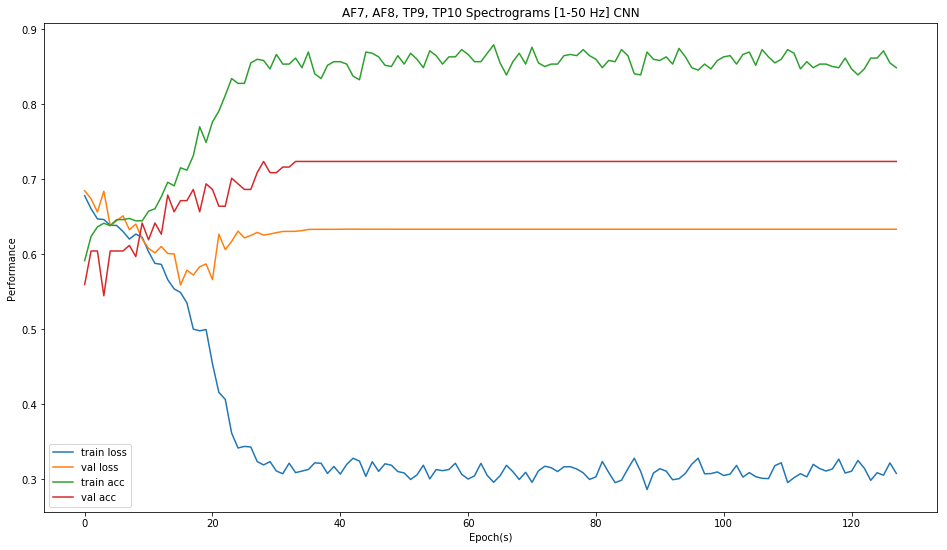

In [7]:
"""
    Output & plot the results
    Aspect Ratio 2 to 1
"""

import matplotlib.pyplot as plt

image_path = './graphs/'
image_name = 'CNN_Spectro_16to9.png'

fig = plt.figure(figsize=(16,9))
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.plot(results.history['acc'], label='train acc')
plt.plot(results.history['val_acc'], label='val acc')
plt.legend(loc='lower left')
plt.title('AF7, AF8, TP9, TP10 Spectrograms [1-50 Hz] CNN')
plt.xlabel('Epoch(s)')
plt.ylabel('Performance')
#plt.show()
plt.savefig(image_path+image_name, bbox_inches='tight')

In [9]:
"""
    Try fetching the model
"""

model_path = './models/'
json_name = 'CNN_Spectro.json'
weight_name = 'CNN_Spectro.h5'

from keras.models import model_from_json

json_file = open(model_path+json_name)
loaded_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_json)
loaded_model.load_weights(model_path+weight_name)
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

loaded_test_score = loaded_model.evaluate(X_test, y_test)
print("\nFinal test %s: %.2f%%" % (loaded_model.metrics_names[1], loaded_test_score[1]*100))

133/133 [==============================] - 0s 3ms/step

Final test acc: 65.41%
